# Linear Regression with Neural Nets
---

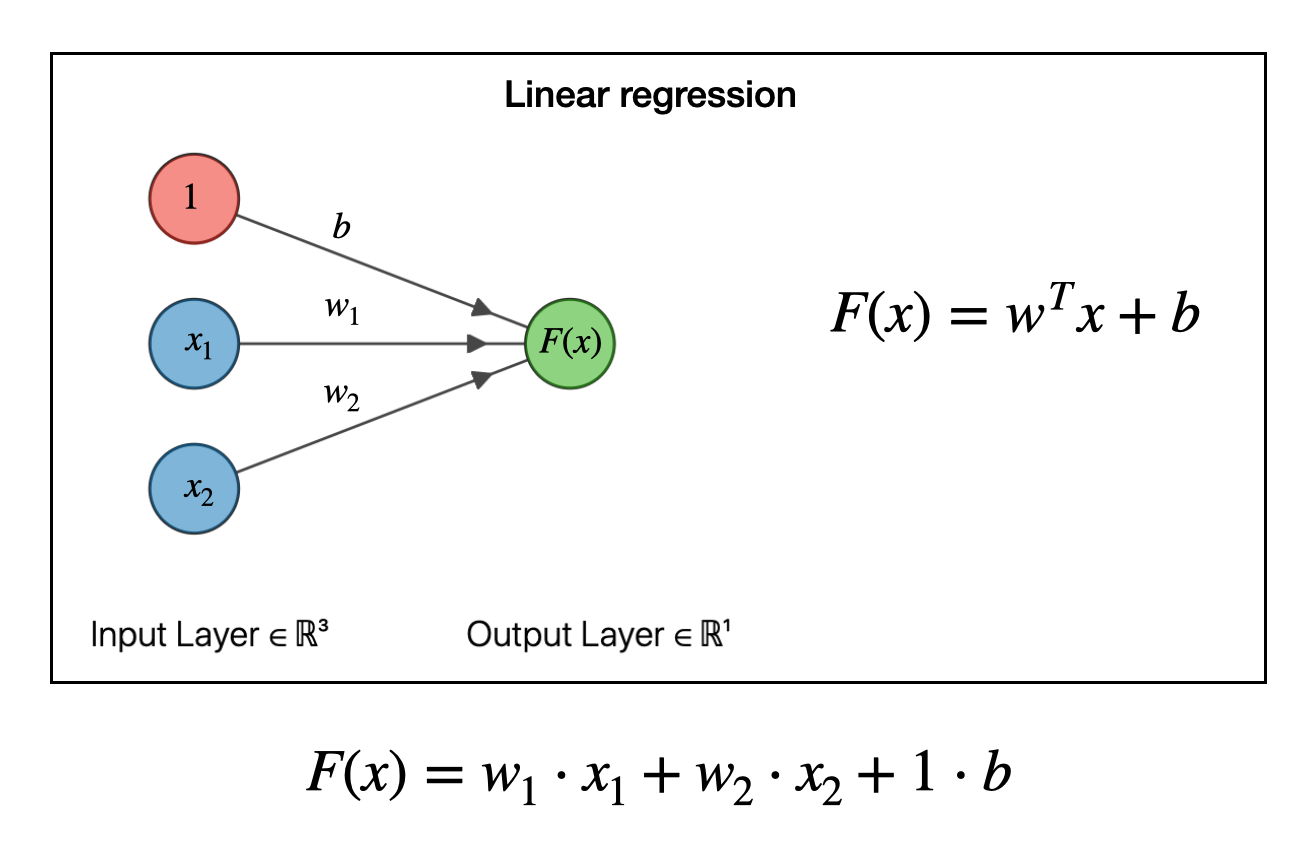

[Source](https://joshuagoings.com/2020/05/05/neural-network/)

### Pytorch implementation

In [ ]:
import numpy as np
import torch
from torch.utils import data
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split

Creating sample data based on a linear function using sklearn library

In [ ]:
from sklearn.datasets import make_regression
# generate regression dataset
features, labels, coef = make_regression(n_samples=1000, n_features=2, noise=0.75, coef=True)

# converting to float type
features = features.astype(np.float32)
labels = labels.astype(np.float32)

# visualizing the data
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter3d(x=features[:,0], y=features[:,1], z=labels, mode='markers'))
fig.show()

In [ ]:
# converting to tensor
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
features_torch, labels_torch = torch.tensor(X_train), torch.unsqueeze(torch.tensor(y_train),1)

## Reading the Dataset

We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.

In [ ]:
def load_array(data_arrays, batch_size):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
batch_size = 10
data_iter_torch = load_array((features_torch, labels_torch), batch_size)

To verify that it is working, we can read and print the first minibatch of examples.

Here, we use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.


In [ ]:
next(iter(data_iter_torch))

[tensor([[-1.5734, -0.2494],
         [ 0.8693, -0.2773],
         [-1.3728,  0.5152],
         [ 0.7676,  0.0323],
         [-0.4708, -0.2956],
         [-0.5956,  1.8680],
         [ 0.6493, -0.1669],
         [-0.4073,  0.2746],
         [ 0.0676, -1.6466],
         [-0.4879,  1.1547]]),
 tensor([[-156.1087],
         [  78.1744],
         [-122.1732],
         [  73.2846],
         [ -49.5041],
         [ -25.3819],
         [  58.1990],
         [ -34.3597],
         [ -21.6935],
         [ -25.6240]])]

## Defining the Model

We use a single layer Neural Network which has a linear layer. To recall this neural network layer optimizes it's weight matrix based on the given data and optimizing function to get a good estimate of labels provided.


In PyTorch, the fully-connected layer is defined in the `Linear` class. Two arguments into `nn.Linear`:
- first one specifies the input feature dimension, which is 2 (refer to the data creation where we used 2 features for x),
- second one is the output feature dimension (estimate of y), which is a single scalar and therefore 1.


In [ ]:
# `nn` is an abbreviation for neural networks
from torch import nn

net_torch = nn.Sequential(nn.Linear(2, 1))

## Initializing Model Parameters

Here we specify that each weight parameter
should be randomly sampled from a normal distribution
with mean 0 and standard deviation 0.01.
The bias parameter will be initialized to zero.


In [ ]:
net_torch[0].weight.data.normal_(0, 0.01)
net_torch[0].bias.data.fill_(0)

tensor([0.])

## Defining the Loss Function


In [ ]:
loss_torch = nn.MSELoss()

## Defining the Optimization Algorithm


When we instantiate an `SGD` instance,
we will specify the parameters to optimize over
(obtainable from our net via `net.parameters()`), with a dictionary of hyperparameters
required by our optimization algorithm.
Minibatch stochastic gradient descent just requires that
we set the value learning rate `lr`, which is set to 0.03 here.


In [ ]:
trainer_torch = torch.optim.SGD(net_torch.parameters(), lr=0.03)

## Training


For some number of epochs, we will make a complete pass over the dataset (`train_data`),
iteratively grabbing one minibatch of inputs
and the corresponding ground-truth labels.
For each minibatch, we go through the following ritual:

* Generate predictions by calling `net(X)` and calculate the loss `l` (the forward propagation).
* Calculate gradients by running the backpropagation.
* Update the model parameters by invoking our optimizer.

For good measure, we compute the loss after each epoch and print it to monitor progress.

Note - In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero (using `zero_grad()`) before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. This accumulating behaviour is convenient while training RNNs or when we want to compute the gradient of the loss summed over multiple mini-batches. So, the default action has been set to accumulate (i.e. sum) the gradients on every loss.backward() call.


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter_torch:
        l = loss_torch(net_torch(X) ,y)
        trainer_torch.zero_grad()
        l.backward()
        trainer_torch.step()
    l = loss_torch(net_torch(features_torch), labels_torch)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 1.251396
epoch 2, loss 0.588834
epoch 3, loss 0.595825
epoch 4, loss 0.590067
epoch 5, loss 0.590160
epoch 6, loss 0.593578
epoch 7, loss 0.590288
epoch 8, loss 0.592210
epoch 9, loss 0.594975
epoch 10, loss 0.592480


In [ ]:
w_torch = net_torch[0].weight.data
print('error in estimating w:', torch.tensor(coef) - w_torch.reshape(coef.shape))

error in estimating w: tensor([0.0396, 0.0215], dtype=torch.float64)


In [ ]:
# visualizing the predictions
preds = np.squeeze(X_test.dot(w_torch.numpy().T))
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter3d(x=X_test[:,0], y=X_test[:,1], z=y_test, mode='markers', name='Actual'))
fig.add_trace(go.Scatter3d(x=X_test[:,0], y=X_test[:,1], z=preds, mode='markers', name='Predicted'))
fig.show()

## TensorFlow
Implementing the same experiment in TF

In [ ]:
import tensorflow as tf

### Reading the dataset

In [ ]:
# converting to tensor
features_tf, labels_tf = tf.convert_to_tensor(X_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)

In [ ]:
def load_array(data_arrays, batch_size):
    """Construct a TensorFlow data iterator."""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

batch_size = 10
data_iter_tf = load_array((features_tf, labels_tf), batch_size)

In [ ]:
next(iter(data_iter_tf))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[-0.84207827,  0.63299227],
        [-1.0328441 , -0.3809219 ],
        [-0.6864218 , -0.03407203],
        [ 0.18758102, -0.33196843],
        [-0.1809046 ,  0.04717898],
        [-0.325067  ,  1.8406103 ],
        [-0.44036284,  1.4670306 ],
        [ 0.15582842,  2.4603295 ],
        [-0.31804442, -0.14418493],
        [-0.52899474,  0.53028166]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ -69.67642   , -105.33389   ,  -66.373695  ,   11.117887  ,
         -17.901278  ,   -0.75306356,  -17.64576   ,   56.071857  ,
         -32.528625  ,  -42.450768  ], dtype=float32)>)

### Defining model and initializing model parameters.
`initializers` module in TensorFlow provides various methods for model parameter initialization. Dense layer in tensorflow is like the linear layer of Torch.

In [ ]:
initializer = tf.initializers.RandomNormal(stddev=0.01)
net_tf = tf.keras.Sequential()
net_tf.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

Defining the loss function

In [ ]:
loss_tf = tf.keras.losses.MeanSquaredError()

Defining the optimizer function and learning rate

In [ ]:
trainer_tf = tf.keras.optimizers.SGD(learning_rate=0.03)

TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs. TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation

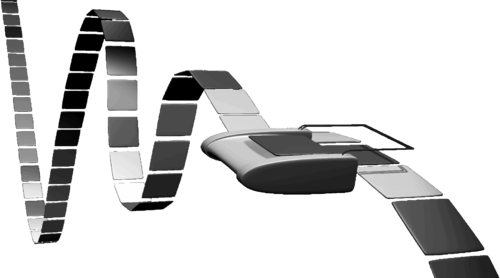

[Source](https://en.wikipedia.org/wiki/Theory_of_computation)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter_tf:
        with tf.GradientTape() as tape:
            l = loss_tf(net_tf(X, training=True), y)
        grads = tape.gradient(l, net_tf.trainable_variables)
        trainer_tf.apply_gradients(zip(grads, net_tf.trainable_variables))
    l = loss_tf(net_tf(features_tf), labels_tf)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 1.401478
epoch 2, loss 0.589326
epoch 3, loss 0.588313
epoch 4, loss 0.592195
epoch 5, loss 0.593229
epoch 6, loss 0.591707
epoch 7, loss 0.589255
epoch 8, loss 0.590240
epoch 9, loss 0.590697
epoch 10, loss 0.592644


In [ ]:
# w = net[0].weight.data
# print('error in estimating w:', torch.tensor(coef) - w.reshape(coef.shape))
w_tf = net_tf.get_weights()[0]
print('error in estimating w', coef - tf.reshape(w_tf, coef.shape))

error in estimating w tf.Tensor([0.0271225  0.05553055], shape=(2,), dtype=float32)


In [ ]:
# visualizing the predictions
preds = np.squeeze(X_test.dot(w_tf))
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter3d(x=X_test[:,0], y=X_test[:,1], z=y_test, mode='markers', name='Actual'))
fig.add_trace(go.Scatter3d(x=X_test[:,0], y=X_test[:,1], z=preds, mode='markers', name='Predicted'))
fig.show()

## LOADING DATASETS
___

### TENSORFLOW


We can download and read the MNIST dataset into memory via the build-in functions in the framework.


In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt


**Reading** the Dataset

In [ ]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()
print(len(mnist_train[0]), len(mnist_test[0]))
print(mnist_train[0][0].shape)
X = tf.constant(mnist_train[0][:18])
y = tf.constant(mnist_train[1][:18])


11490434/11490434 [==============================] - 0s 0us/step
60000 10000
(28, 28)


In [ ]:
def get_mnist_labels_tf(labels):
    text_labels = ['0','1','2','3','4','5','6','7','8','9']
    return [text_labels[int(i)] for i in labels]

def show_images_tf(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()

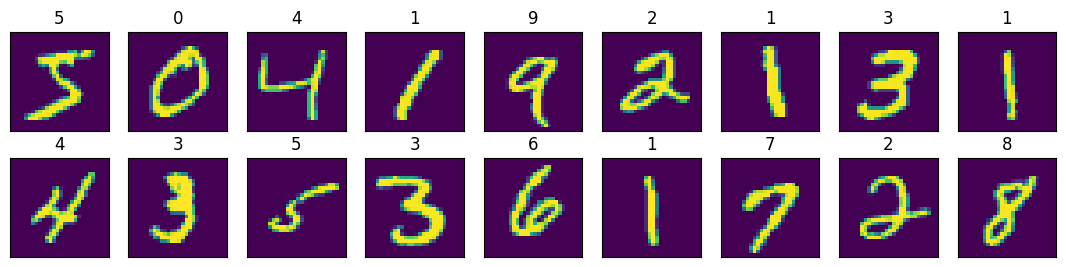

In [ ]:
show_images_tf(X, 2, 9, titles=get_mnist_labels_tf(y))

Reading a Minibatch

In [ ]:
batch_size = 256
train_iter = tf.data.Dataset.from_tensor_slices(mnist_train).batch(batch_size).shuffle(len(mnist_train[0]))
print(len(train_iter))

235


Putting it all together

In [ ]:
def load_data_mnist_tf(batch_size, resize=None):

    # load dataset
    mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

    # normalisation and cast as Int datatype
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,tf.cast(y, dtype='int32'))

    # resize images if resize is not None
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, resize, resize) if resize else X, y)

    # load train and test batches
    train_iter = tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(batch_size).shuffle(len(mnist_train[0])).map(resize_fn)
    test_iter = tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(batch_size).map(resize_fn)

    return (train_iter, test_iter)

train_iter, test_iter = load_data_mnist_tf(batch_size, resize=64)

for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break


(256, 64, 64, 1) <dtype: 'float32'> (256,) <dtype: 'int32'>


### PYTORCH


100%|██████████| 9912422/9912422 [00:00<00:00, 188102409.41it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30839025.92it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45536733.48it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12500346.96it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


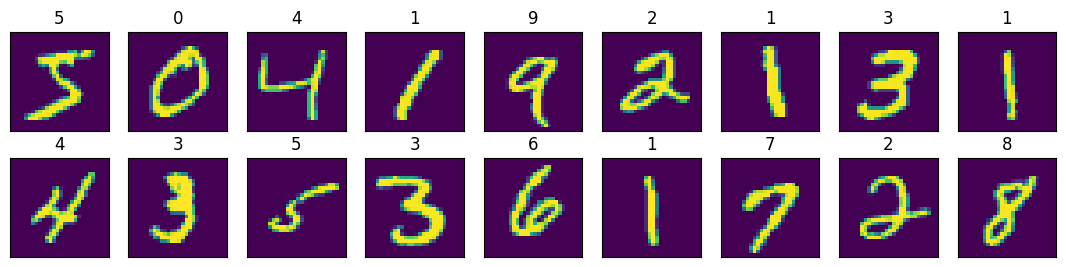

In [ ]:
import torch
from torch import nn
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans, download=True)

def get_mnist_labels_pt(labels):
    """Return text labels for the MNIST dataset."""
    text_labels = ['0','1','2','3','4','5','6','7','8','9']
    return [text_labels[int(i)] for i in labels]

def show_images_pt(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images_pt(X.reshape(18, 28, 28), 2, 9, titles=get_mnist_labels_pt(y))

batch_size = 256

def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())


def load_data_mnist_pt(batch_size, resize=None):
  trans = [transforms.ToTensor()]
  if resize:
      trans.insert(0, transforms.Resize(resize))

  trans = transforms.Compose(trans)

  # load dataset
  mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans, download=True)

  #load train and test batches
  train = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())
  test = data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers())

  return (train, test)


train_iter, test_iter = load_data_mnist_pt(32, resize=64)

for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

### EXERCISE : TENSORFLOW

In [ ]:
# TO DO:
# Load the Fashion MNIST data

def get_fashion_mnist_labels_tf(labels):

  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

def load_data_fashion_mnist_tf(batch_size, resize=None):

    # load dataset
  fmnist_train, fmnist_test = tf.keras.datasets.fashion_mnist.load_data()

    # normalisation and cast as Int datatype
  process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,tf.cast(y, dtype='int32'))

    # resize images if resize is not None
  resize_fn = lambda X, y: (tf.image.resize_with_pad(X, resize, resize) if resize else X, y)

    # load train and test batches
  train_iter = tf.data.Dataset.from_tensor_slices(process(*fmnist_train)).batch(batch_size).shuffle(len(fmnist_train[0])).map(resize_fn)
  test_iter = tf.data.Dataset.from_tensor_slices(process(*fmnist_test)).batch(batch_size).map(resize_fn)

  return (train_iter, test_iter)



### EXERCISE : PYTORCH

In [ ]:
# TO DO:
# Load the Fashion MNIST data

def get_fashion_mnist_labels_pt(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def load_data_fashion_mnist_pt(batch_size, resize=None):
  """
    To Do:
    Write a function to load data for the Fashion-MNIST dataset.
  """
  trans = [transforms.ToTensor()]
  if resize:
      trans.insert(0, transforms.Resize(resize))

  trans = transforms.Compose(trans)

  # load dataset
  fmnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
  fmnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

  #load train and test batches
  train = data.DataLoader(fmnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())
  test = data.DataLoader(fmnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers())

  return (train, test)

## MULTI LAYER PERCEPTRON

Hidden Layers


Layers after the input layer are called hidden layers because that are not directly exposed to the input. The simplest network structure is to have a single neuron in the hidden layer that directly outputs the value.

Given increases in computing power and efficient libraries, very deep neural networks can be constructed. Deep learning can refer to having many hidden layers in your neural network. They are deep because they would have been unimaginably slow to train historically, but may take seconds or minutes to train using modern techniques and hardware.

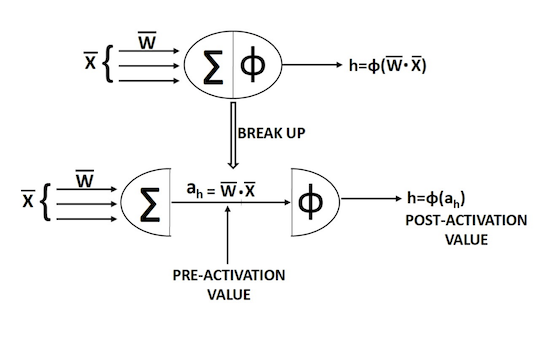

### TENSORFLOW

In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

#reshape data from 3-D to 2-D array
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

#feature scaling
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
#fit and transform training dataset
x_train = minmax.fit_transform(x_train)
#transform testing dataset
x_test = minmax.transform(x_test)

# options
batch_size = 64   # input batch size for training
epochs = 5      # number of epochs to train
lr = 0.01        # learning rate


# neural network
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)])


net.compile(optimizer='sgd', loss='sparse_categorical_crossentropy')
net.fit(x_train, y_train, epochs= epochs, batch_size = batch_size)



(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Epoch 1/5
938/938 [==============================] - 7s 7ms/step - loss: 6.3231
Epoch 2/5
938/938 [==============================] - 3s 4ms/step - loss: 8.3670
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 8.3626
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 8.3626
Epoch 5/5
938/938 [==============================] - 3s 4ms/step - loss: 8.3629


### PYTORCH

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# options
batch_size = 64   # input batch size for training
epochs = 5      # number of epochs to train
lr = 0.01        # learning rate

data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

network = net
optimizer = optim.SGD(network.parameters(), lr=lr)

train_losses = []
train_loss_steps = []
train_accuracy = []

def train(epoch):
    network.train()
    correct = 0
    val_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        val_loss += loss
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    val_loss /=len(train_loader.dataset)
    train_losses.append(val_loss)
    train_accuracy.append(100. * correct / len(train_loader.dataset))

for i in range(epochs):
  train(i)


100%|██████████| 9912422/9912422 [00:00<00:00, 144487538.47it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19930189.84it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44355952.47it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12641359.50it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.323330
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.951133
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.579813
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.446581
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.465097
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.460392
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.243736
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.389052
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.206315
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.253725
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.170526
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.386985
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.318739
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.229772
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.135163
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.338970
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.224724
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.220862
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.2147

### EXERCISE : TENSORFLOW

refer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [ ]:
"""
TO DO:

Make a squential network for the Fashion MNIST dataset and train it for 10 epochs.

Use:
- Batch Size = 128
- Loss = SparseCategoricalCrossEntropy
- Optimizer  = Adam
- Learning Rate = 0.01
"""

import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

#reshape data from 3-D to 2-D array
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

#feature scaling
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
#fit and transform training dataset
x_train = minmax.fit_transform(x_train)
#transform testing dataset
x_test = minmax.transform(x_test)

# options
batch_size = 128   # input batch size for training
epochs = 10     # number of epochs to train
lr = 0.01        # learning rate


# neural network
net = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)])


net.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
net.fit(x_train, y_train, epochs= epochs, batch_size = batch_size)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Epoch 1/10
469/469 [==============================] - 6s 11ms/step - loss: 0.5332
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.3921
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.3511
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 0.3188
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.2992
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2822
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2737
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2618
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2516
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.2411


### EXERCISE: PYTORCH

refer: https://pytorch.org/docs/stable/optim.html

In [ ]:
"""
Make a squential network for the Fashion MNIST dataset and train it for 10 epochs.

Use:
- Batch Size = 128
- Loss = CrossEntropy
- Optimizer  = Adam
- Learning Rate = 0.01

"""


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# options
batch_size = 128   # input batch size for training
epochs = 10     # number of epochs to train
lr = 0.01        # learning rate

data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.FashionMNIST(root='.', train=True, download=True, transform=data_transform)
testset = datasets.FashionMNIST(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

network = net
optimizer = optim.Adam(network.parameters(), lr=lr)

train_losses = []
train_loss_steps = []
train_accuracy = []

def train(epoch):
    network.train()
    correct = 0
    val_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        val_loss += loss
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    val_loss /=len(train_loader.dataset)
    train_losses.append(val_loss)
    train_accuracy.append(100. * correct / len(train_loader.dataset))

for i in range(epochs):
  train(i)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.402744
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.420878
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.496510
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.425183
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.368345
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.275324
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.425596
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.351572
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.380875
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.462866
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.275800
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.403335
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.384540
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.347469
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.530187
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.367230
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.493637
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.253949
Train Epoch: 3 [38400/60000 (64%)]	Loss: 

### References
---
 - http://d2l.ai/chapter_linear-networks/linear-regression-concise.html
 - http://d2l.ai/chapter_linear-networks/image-classification-dataset.html
 - http://d2l.ai/chapter_multilayer-perceptrons/mlp-concise.html